# 1. Install dependencies

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# !rm -rf IT1244_data
!git clone https://github.com/ContainerWhale/IT1244_data.git

Cloning into 'IT1244_data'...
remote: Enumerating objects: 271, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 271 (delta 7), reused 6 (delta 0), pack-reused 226
Receiving objects: 100% (271/271), 5.92 MiB | 23.33 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [3]:
# Download the second Python file from GitHub
!wget https://raw.githubusercontent.com/ContainerWhale/IT1244_data/main/Code/Symmetry.py

import Symmetry

--2024-04-05 15:15:24--  https://raw.githubusercontent.com/ContainerWhale/IT1244_data/main/Code/Symmetry.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10964 (11K) [text/plain]
Saving to: ‘Symmetry.py’

Symmetry.py         100%[===================>]  10.71K  --.-KB/s    in 0s      

2024-04-05 15:15:24 (120 MB/s) - ‘Symmetry.py’ saved [10964/10964]



In [4]:
from Symmetry import extractLine

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
from sklearn.model_selection import train_test_split

# 2. Read image files

In [6]:
yes_path = "/content/IT1244_data/Brain Tumor/data/malignant/*.jpg"
no_path = "/content/IT1244_data/Brain Tumor/data/benign/*.jpg"
size = 128
yes, no = [], []
for f in glob.iglob(yes_path):
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = crop_to_fit(img, 300)
    img = cv2.resize(img, (size, size))
    yes.append(img)

for f in glob.iglob(no_path):
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = crop_to_fit(img, 300)
    img = cv2.resize(img, (size, size))
    no.append(img)





# 3. Split the data

In [7]:
X_img = (yes + no)
y = np.array([1 if i < len(yes) else 0 for i in range(len(yes)+len(no))])

In [8]:
seed = 1244
X_tv_img, X_test_img, y_tv, y_test = train_test_split(X_img, y, test_size=0.1, random_state=seed)
X_train_img, X_val_img, y_train, y_val = train_test_split(X_tv_img, y_tv, test_size=0.3, random_state=seed)

# 4. Data processing

## 4a. Feature extraction

In [9]:
train_temp = extractLine(X_train_img)
val_temp = extractLine(X_val_img)
test_temp = extractLine(X_test_img)


Uncomment to draw symmetry line on all images

In [10]:
# X_train_img = train_temp.draw_all()
# X_val_img = val_temp.draw_all()

In [11]:
X_train_ftr = np.expand_dims(train_temp.get_sym(), axis=1)
X_val_ftr = np.expand_dims(val_temp.get_sym(), axis=1)
X_test_ftr = np.expand_dims(test_temp.get_sym(), axis=1)

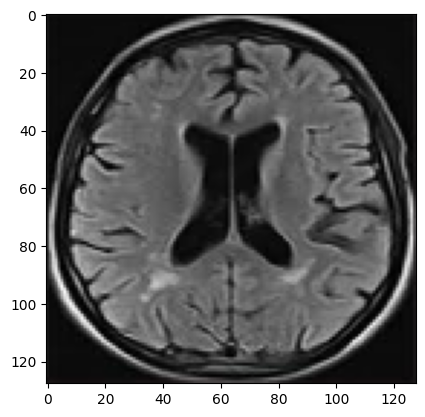

In [12]:
plt.imshow(X_train_img[10])

{'whiskers': [<matplotlib.lines.Line2D at 0x78ad9b23a830>,
 'caps': [<matplotlib.lines.Line2D at 0x78ad9b23ad70>,
 'boxes': [<matplotlib.lines.Line2D at 0x78ad9b23a590>,
 'medians': [<matplotlib.lines.Line2D at 0x78ad9b23b2b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x78ad9b23b550>,
 'means': []}

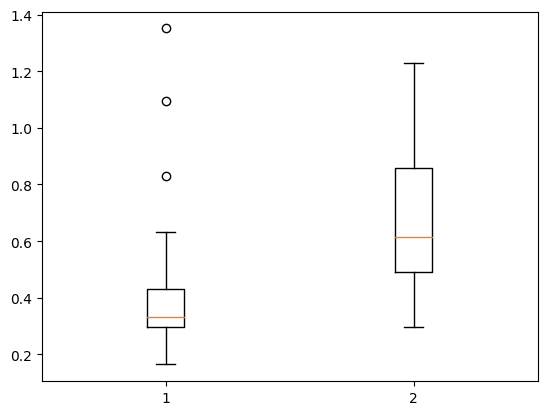

In [13]:
X_train_ftr = np.array(X_train_ftr)
y_train = np.array(y_train)
malignant = X_train_ftr.flatten()[y_train == 1]
benign = X_train_ftr.flatten()[y_train == 0]
plt.boxplot([benign, malignant])

## 4b. Augmentation

In [14]:
from tensorflow.keras import layers

def random_invert_img(x, p=0.5, seed=None):
    if not (seed is None):
        tf.random.set_seed(seed)
    if tf.random.uniform([]) < p:
        x = (255-x)
    return x

# def random_invert(factor=0.5):
#   return layers.Lambda(lambda x: random_invert_img(x, factor))

# random_invert = random_invert()

class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, seed=None, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor
    self.seed = seed

  def call(self, x):
    return random_invert_img(x, seed)

In [15]:
data_augmentation = tf.keras.Sequential([
  RandomInvert(),
  layers.RandomContrast(0.4, seed=seed),
  layers.RandomBrightness(0.2, seed=seed),
  layers.RandomFlip("horizontal_and_vertical", seed=seed),
  layers.RandomRotation(0.1, fill_mode="nearest", seed=seed),
  layers.RandomZoom((-0.2, 0.2), fill_mode="nearest", seed=seed),
#   layers.Rescaling(1./255)
])


Can choose to inflate the benign batches to inflate the benign data to even out the dataset (uncomment and comment the necessary code to enable)

In [16]:
batch_mal = 6 # number of new augmented images to be generated per sample for malignant,
# benign batch sizes are inflated accordingly to even out the dataset (uncomment and comment the necessary code to enable)
b, m = sum(y_train == 0), sum(y_train == 1)
# batch_ben = m * (batch_mal + 1) // b - 1 # uncomment this
batch_ben = batch_mal # comment this
print(f"malignant: {batch_mal}\nbenign: {batch_ben}")

X_train_img_aug, X_train_ftr_aug, y_train_aug = [], [], []


for i in range(len(X_train_img)):
    X_train_img_aug.append(X_train_img[i])
    X_train_ftr_aug.append(X_train_ftr[i])
    y_train_aug.append(y_train[i])

    batch = batch_mal if y_train[i] == 1 else batch_ben
    for _ in range(batch):
        new = data_augmentation(X_train_img[i])

        new = np.array(new).astype("uint8")

        X_train_img_aug.append(new)
        X_train_ftr_aug.append(X_train_ftr[i])
        y_train_aug.append(y_train[i])

sum(y_train_aug)/len(y_train_aug)

malignant: 6
benign: 6


0.6597222222222222

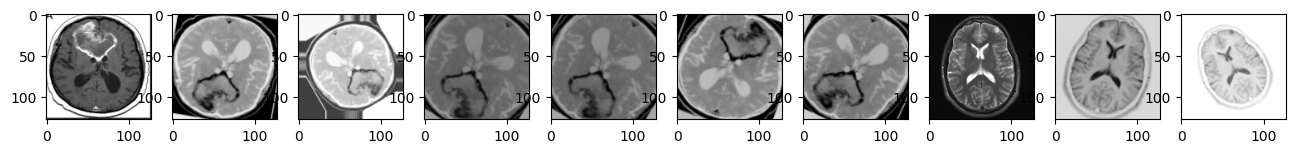

In [17]:
plt.figure(figsize=(16,9))
for i,img in enumerate(X_train_img_aug[:10]):
    plt.subplot(1, 10, i+1)
    plt.imshow(img)

## 4c. Standardisation

In [18]:
def dataset_standardise_img(dataset):
    '''
    dataset: numpy array of shape (N, ...)
    returns standardised values for each observation, numpy array of shape (N, ...) using dataset standardisation
    '''
    dataset = np.array(dataset)
    mean = np.mean(dataset)
    std = np.std(dataset)

    return (dataset - mean) / std

def standardise_img(dataset):
    '''
    dataset: numpy array of shape (N, ...)
    returns standardised values for each observation, numpy array of shape (N, ...) using per-image standardisation
    '''
    dataset = np.array(dataset)
    l = len(dataset.shape)
    tup = tuple(range(1,l))
    mean = np.mean(dataset, axis=tup, keepdims=True)
    std = np.std(dataset, axis=tup, keepdims=True)

    return (dataset - mean) / std

def standardise_col(dataset):
    '''
    dataset: numpy array of shape (N, D)
    standardises each column
    returns standardised dataset of shape (N, D)
    '''
    dataset = np.array(dataset)
    mean = np.mean(dataset, axis=0)
    std = np.std(dataset, axis=0)
    return (dataset - mean) / std

Comment and uncomment the necessary code to switch between these 3 options:
1.	Normalisation of images
2.	Per-image standardisation of images
3.	Dataset standardisation of images


In [19]:
# Augmentation, normalised
# X_train_img_std = np.array(X_train_img_aug) / 255
# X_val_img_std = np.array(X_val_img) / 255
# X_test_img_std = np.array(X_test_img) / 255
# X_train_ftr_std = standardise_col(X_train_ftr_aug)
# X_val_ftr_std = standardise_col(X_val_ftr)
# X_test_ftr_std = standardise_col(X_test_ftr)
# y_train_std = np.array(y_train_aug)

# Augmentation, per-image standardised
X_train_img_std = standardise_img(X_train_img_aug)
X_val_img_std = standardise_img(X_val_img)
X_test_img_std = standardise_img(X_test_img)
X_train_ftr_std = standardise_col(X_train_ftr_aug)
X_val_ftr_std = standardise_col(X_val_ftr)
X_test_ftr_std = standardise_col(X_test_ftr)
y_train_std = np.array(y_train_aug)

# Augmentation, dataset standardised
# X_train_img_std = dataset_standardise_img(X_train_img_aug)
# X_val_img_std = dataset_standardise_img(X_val_img)
# X_test_img_std = dataset_standardise_img(X_test_img)
# X_train_ftr_std = standardise_col(X_train_ftr_aug)
# X_val_ftr_std = standardise_col(X_val_ftr)
# X_test_ftr_std = standardise_col(X_test_ftr)
# y_train_std = np.array(y_train_aug)


In [20]:
np.max(X_train_img_std)

6.585264626175413

In [21]:
[type(x) for x in (X_train_img_std, X_val_img_std, y_train_std, y_val, X_train_ftr_std, X_val_ftr_std)]

[numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray]

Applying symmetry metric on augmented images (the distinction between malignant and benign becomes worse)

In [22]:
# X_temp = np.array(X_train_img_aug)
# plt.boxplot([get_sym(X_temp[y_train_std == 0]), get_sym(X_temp[y_train_std == 1])])

# 5. The model class

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras import layers, models, optimizers
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Dense, Dropout, concatenate, Input, BatchNormalization
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

class CNNModel():
    def __init__(self, model_name,
                 X_train_img, X_val_img,
                 y_train, y_val,
                 X_train_ftr = None, X_val_ftr = None) -> None:

        '''Let there be T training samples and V validation samples and n features
        model_name: name of model as string (e.g. "VGG16", "InceptionResNetV2")
        X_train_img: numpy array of shape (T, 128, 128, 3)
        X_val_img: numpy array of shape (V, 128, 128, 3)
        y_train: numpy array of shape (T,), with binary values
        y_val: numpy array of shape (V,), with binary values
        X_train_ftr: (Optional) numpy array of shape (T, n)
        X_val_ftr: (Optional) numpy array of shape (V, n)
        '''

        self.X_train_img, self.X_val_img = X_train_img, X_val_img
        self.y_train, self.y_val = y_train, y_val
        self.using_ftr = True

        if X_train_ftr is None or X_val_ftr is None:
            self.X_train_ftr = np.empty((X_train_img.shape[0], 0))
            self.X_val_ftr = np.empty((X_val_img.shape[0], 0))
            self.using_ftr = False
            pass
        else:
            self.X_train_ftr = X_train_ftr
            self.X_val_ftr = X_val_ftr

        if model_name == "VGG16":
            self.model = self._create_VGG16_model(X_train_img.shape[1:], self.X_train_ftr.shape[1:])
        elif model_name == "InceptionResNetV2":
            self.model = self._create_InceptionResNetV2_model(X_train_img.shape[1:], self.X_train_ftr.shape[1:])
        elif model_name == "ResNet50":
            self.model = self._create_ResNet50_model(X_train_img.shape[1:], self.X_train_ftr.shape[1:])
        else:
            self.model = None

        self.model_name = model_name
        self.history = None
        self.ft_model = None
        self.ft_history = None
        self.y_pred = None

    ### Models ###
    def _create_VGG16_model(self, image_shape, feature_shape):
        # Defining inputs
        image_input = Input(shape=image_shape, name="image_input")
        feature_input = Input(shape=feature_shape, name='feature_input')

        # Constructing VGG16 model
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)
        base_model.trainable = False

        out = GlobalMaxPooling2D()(base_model.output)
        out = Dense(64, activation="relu")(out)
        out = Dropout(0.5)(out)
        out = concatenate([out, feature_input])
        out = Dense(1, activation="sigmoid")(out)

        model = Model(inputs = [image_input, feature_input], outputs = out)

        # model.layers[16].trainable = True
        # model.layers[17].trainable = True
        return model

    def _create_InceptionResNetV2_model(self, image_shape, feature_shape):
        # Defining inputs
        image_input = Input(shape=image_shape, name="image_input")
        feature_input = Input(shape=feature_shape, name='feature_input')

        # Constructing Inception model
        base_model = keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=image_input)
        base_model.trainable = False

        out = GlobalMaxPooling2D()(base_model.output)
        out = concatenate([out, feature_input])
        out = BatchNormalization()(out)
        out = Dropout(0.6)(out)
        out = Dense(1, activation="sigmoid")(out)

        model = Model(inputs = [image_input, feature_input], outputs = out)

        return model


    def _create_ResNet50_model(self, image_shape, feature_shape):
        # Defining inputs
        image_input = Input(shape=image_shape, name="image_input")
        feature_input = Input(shape=feature_shape, name='feature_input')

        # Constructing resnet50 model
        base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)
        base_model.trainable = False

        out = GlobalMaxPooling2D()(base_model.output)
        out = concatenate([out, feature_input])
        out = BatchNormalization()(out)
        out = Dropout(0.6)(out)
        out = Dense(1, activation="sigmoid")(out)

        model = Model(inputs = [image_input, feature_input], outputs = out)

        return model

    ### End of models ###

    ### Training methods ###
    def get_summary(self):
        if self.model is None:
            print("No model")
            return
        else:
            model = self.model
        print(f"Model input names: {model.input_names}")
        print()
        for i, layer in enumerate(model.layers):
            print(f"{i}\t{layer.__class__.__name__}   \t{layer.trainable}")

    def run_model(self, epochs, batch_size):
        '''
        epochs: epochs
        batch_size: batch_size

        returns history
        '''
        if self.model is None:
            print("No model")
            return

        X_train = {'image_input': self.X_train_img, 'feature_input': self.X_train_ftr}
        X_val = {'image_input': self.X_val_img, 'feature_input': self.X_val_ftr}

        # Compile the model
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        history = self.model.fit(x = X_train, y = self.y_train,
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(X_val, self.y_val))
        self.history = history
        return history

    def fine_tune(self, target_name, epochs, batch_size, l_rate=1e-5):
        '''
        target_name: name of layer to set to trainable and thereafter
        epochs: epochs
        batch_size: batch_size
        l_rate: learning rate, default 1e-5

        returns history
        '''
        from keras.models import clone_model

        if self.model is None:
            print("No model")
            return

        self.ft_model = clone_model(self.model)
        self.ft_model.set_weights(self.model.get_weights())


        set_trainable = False
        for layer in self.ft_model.layers:
            if layer.name == target_name:
                layer.trainable = True
                set_trainable = True
            layer.trainable = True if set_trainable else False

        X_train = {'image_input': self.X_train_img, 'feature_input': self.X_train_ftr}
        X_val = {'image_input': self.X_val_img, 'feature_input': self.X_val_ftr}


        self.ft_model.compile(optimizer=keras.optimizers.Adam(l_rate), loss='binary_crossentropy', metrics=['accuracy'])

        history = self.ft_model.fit(x = X_train, y = self.y_train,
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(X_val, self.y_val))
        self.ft_history = history
        return history

    def fine_tune_again(self, epochs, batch_size, l_rate=1e-5):
        X_train = {'image_input': self.X_train_img, 'feature_input': self.X_train_ftr}
        X_val = {'image_input': self.X_val_img, 'feature_input': self.X_val_ftr}

        self.ft_model.compile(optimizer=keras.optimizers.Adam(l_rate), loss='binary_crossentropy', metrics=['accuracy'])

        history = self.ft_model.fit(x = X_train, y = self.y_train,
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(X_val, self.y_val))

        return history

    def get_model(self):
        return self.model
    ### End of training methods ###


    ### Data Analysis ###
    def _plot_loss_curve(self, history1):
        df = pd.DataFrame(history1.history)

        # History for loss
        ax = df[["loss", "val_loss"]].plot()
        ax.legend(["Training loss", "Testing loss"])
        plt.xlabel("# of epochs")
        plt.ylabel("Loss")
        plt.show()

        # History for accuracy
        ax = df[["accuracy", "val_accuracy"]].plot()
        ax.legend(["Training accuracy", "Testing accuracy"])
        plt.xlabel("# of epochs")
        plt.ylabel("Accuracy")
        plt.show()


    def _show_confusion_matrix(self, model, fancy, test_data):

        if test_data:
            X_val_img = test_data[0]
            X_val_ftr = test_data[1]
            y_val = test_data[2]
        else:
            X_val_img = self.X_val_img
            X_val_ftr = self.X_val_ftr
            y_val = self.y_val

        X_val_img, X_val_ftr = np.array(X_val_img), np.array(X_val_ftr)

        if not self.using_ftr:
            # Run this if not using ftr
            empty = np.empty((X_val_img.shape[0], 0))
            y_pred = model.predict([X_val_img, empty])[:,0]
        else:
            # Run this if using ftr
            y_pred = model.predict([X_val_img, X_val_ftr])[:,0]
        y_pred_classes = (y_pred > 0.5).astype(int)
        cm = confusion_matrix(y_val, y_pred_classes)

        if fancy:
            sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Confusion Matrix')
            plt.show()

        # Print the confusion matrix as a table
        print("Confusion Matrix:")
        print(cm)

        # Accuracy
        acc = (cm[0,0] + cm[1,1]) / np.sum(cm)
        # Miss rate
        miss = (cm[1,0]/np.sum(cm[1,:]))
        #F1 score
        f1 = 2/(1/acc + 1/(1-miss))
        print(acc, miss, f1)
        if test_data is None:
            self.y_pred = y_pred

    def plot_loss_curve(self):
        try:
            print("Training curves")
            self._plot_loss_curve(self.history)
        except:
            print("None")
        try:
            print("Fine tuning curves")
            self._plot_loss_curve(self.ft_history)
        except:
            print("None")

    def show_confusion_matrix(self, fancy=False, test_data=None):
        try:
            print("Before fine tuning set")
            self._show_confusion_matrix(self.model, fancy, test_data)
        except:
            print("None")
        try:
            print("After fine tuning set")
            self._show_confusion_matrix(self.ft_model, fancy, test_data)
        except:
            print("None")


    def show_misclassified(self, X_val_img, show_sym=False):
        '''
        Works for validation set only
        X_val_img: Original rgb validation images
        '''

        if self.y_pred is None:
            print("No predictions")
        X_val_img = np.array(X_val_img)
        # False negatives (miss)
        print("FN")
        indices = (self.y_pred < 0.5) * (self.y_val > 0.5)
        print(f"Indices: {np.where(indices)[0]}")
        FN = X_val_img[indices]
        FN = FN.astype(int)
        if show_sym:
            print(f"Symmetry metric:\n{self.X_val_ftr[indices]}")

        plt.figure(figsize=(16,9))
        for i in range(len(FN)):
            plt.subplot(1, len(FN), i+1)
            plt.title("FN")
            plt.imshow(FN[i])
        plt.show()

        # False positives (false alarm)
        print("FP")
        indices = (self.y_pred > 0.5) * (self.y_val < 0.5)
        print(f"Indices: {np.where(indices)[0]}")
        FP = X_val_img[indices]
        FP = FP.astype(int)
        if show_sym:
            print(f"Symmetry metric:\n{self.X_val_ftr[indices]}")

        plt.figure(figsize=(16,9))
        for i in range(len(FP)):
            plt.subplot(1, len(FP), i+1)
            plt.title("FP")
            plt.imshow(FP[i])
        plt.show()


# 5a. Fitting the model
Comment/Uncomment to initiate/train models

Note: resnet_model_wosym is the model trained without the input of the symmetry metric

In [37]:
# Defining the object
# vgg_model = CNNModel("VGG16", X_train_img_std, X_val_img_std, y_train_std, y_val, X_train_ftr_std, X_val_ftr_std)
# inception_model = CNNModel("InceptionResNetV2", X_train_img_std, X_val_img_std, y_train_std, y_val, X_train_ftr_std, X_val_ftr_std)
resnet_model = CNNModel("ResNet50", X_train_img_std, X_val_img_std, y_train_std, y_val, X_train_ftr_std, X_val_ftr_std)
# resnet_model_wosym = CNNModel("ResNet50", X_train_img_std, X_val_img_std, y_train_std, y_val)

# Get summary
# resnet_model.get_summary()
# resnet_model.model.summary()

# Initial training
# vgg_model.run_model(12, 32)
# inception_model.run_model(10, 32)
resnet_model.run_model(10, 32)
# resnet_model_wosym.run_model(10, 32)

Epoch 1/10
32/32 [==============================] - 6s 83ms/step - loss: 0.8301 - accuracy: 0.5873 - val_loss: 0.5386 - val_accuracy: 0.7619
Epoch 2/10
32/32 [==============================] - 1s 37ms/step - loss: 0.5773 - accuracy: 0.7421 - val_loss: 0.4630 - val_accuracy: 0.7619
Epoch 3/10
32/32 [==============================] - 1s 37ms/step - loss: 0.4936 - accuracy: 0.7808 - val_loss: 0.4075 - val_accuracy: 0.8571
Epoch 4/10
32/32 [==============================] - 1s 37ms/step - loss: 0.4286 - accuracy: 0.8115 - val_loss: 0.4070 - val_accuracy: 0.8730
Epoch 5/10
32/32 [==============================] - 1s 37ms/step - loss: 0.3627 - accuracy: 0.8452 - val_loss: 0.3769 - val_accuracy: 0.8730
Epoch 6/10
32/32 [==============================] - 1s 40ms/step - loss: 0.3620 - accuracy: 0.8502 - val_loss: 0.3760 - val_accuracy: 0.8889
Epoch 7/10
32/32 [==============================] - 1s 37ms/step - loss: 0.3350 - accuracy: 0.8571 - val_loss: 0.3743 - val_accuracy: 0.8730
Epoch 8/10
32

Visualisation of model.summary

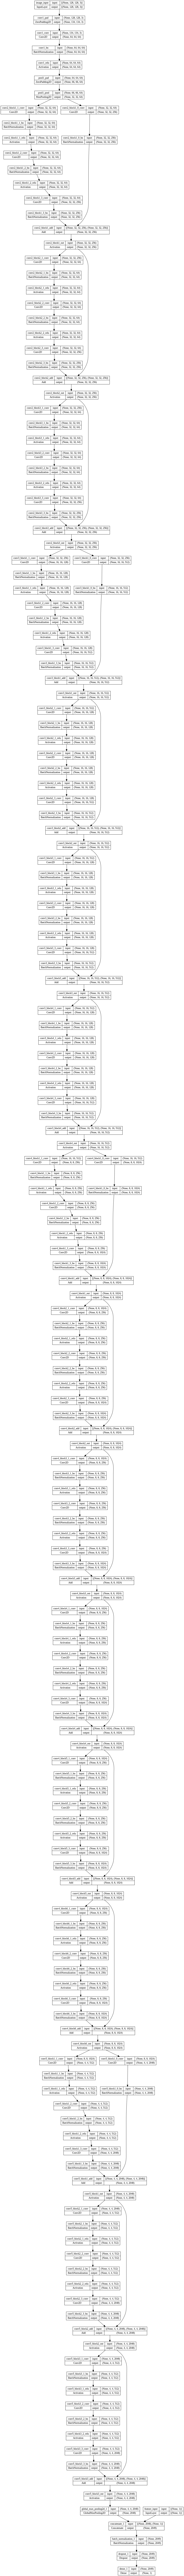

In [38]:
tf.keras.utils.plot_model(resnet_model.model, to_file='last_layers_model_summary.png', show_shapes=True)

#5b. Fine tune

In [39]:
# vgg_model.fine_tune(target_name="block4_conv1", epochs=5, batch_size=16)
# inception_model.fine_tune(target_name="block8_10_mixed", epochs=8, batch_size=32)
resnet_model.fine_tune(target_name="conv4_block1_1_conv", epochs=5, batch_size=32)
# resnet_model_wosym.fine_tune(target_name="conv4_block1_1_conv", epochs=5, batch_size=32)

Epoch 1/5
32/32 [==============================] - 21s 116ms/step - loss: 0.6448 - accuracy: 0.7401 - val_loss: 0.3282 - val_accuracy: 0.9048
Epoch 2/5
32/32 [==============================] - 3s 84ms/step - loss: 0.4007 - accuracy: 0.8403 - val_loss: 0.3249 - val_accuracy: 0.8730
Epoch 3/5
32/32 [==============================] - 3s 79ms/step - loss: 0.2531 - accuracy: 0.8909 - val_loss: 0.3788 - val_accuracy: 0.8254
Epoch 4/5
32/32 [==============================] - 3s 83ms/step - loss: 0.1844 - accuracy: 0.9335 - val_loss: 0.3998 - val_accuracy: 0.8095
Epoch 5/5
32/32 [==============================] - 3s 79ms/step - loss: 0.1531 - accuracy: 0.9355 - val_loss: 0.3832 - val_accuracy: 0.8413


In [40]:
# resnet_model.fine_tune_again(2, 32, l_rate=1e-6)

# 6. Data analysis

Training curves


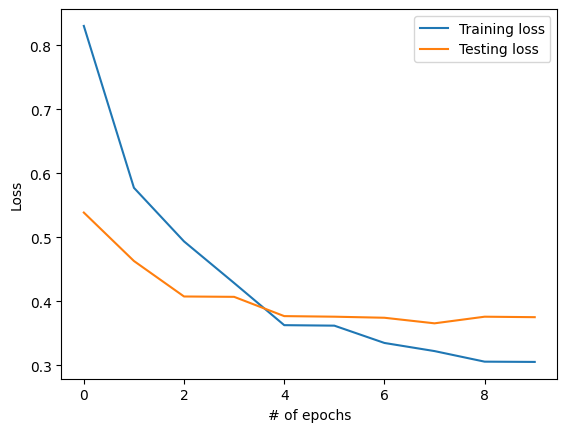

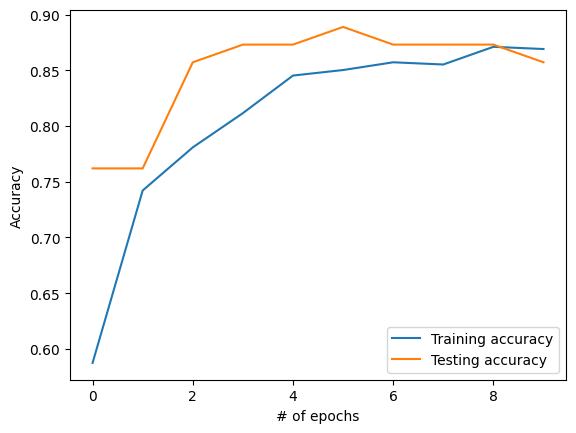

Fine tuning curves


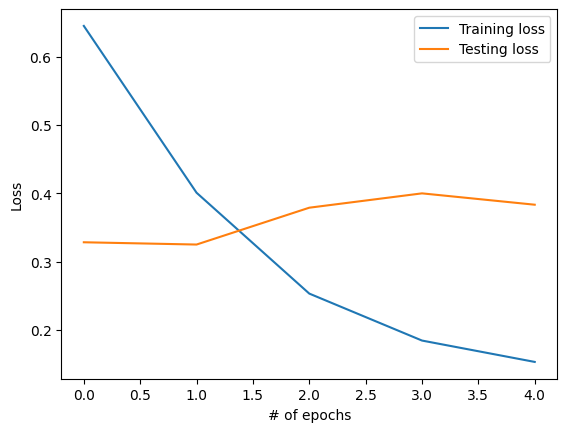

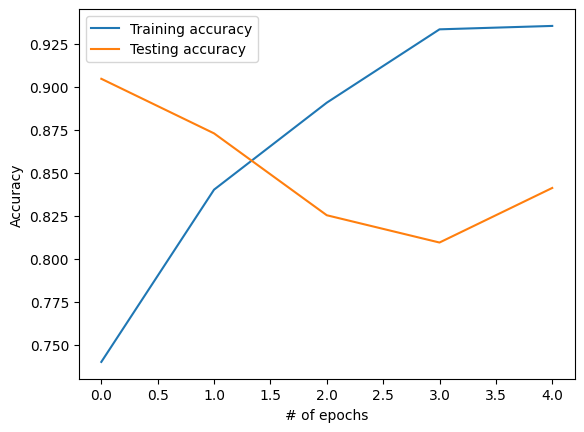

In [41]:
resnet_model.plot_loss_curve()

Before fine tuning set
2/2 [==============================] - 1s 39ms/step


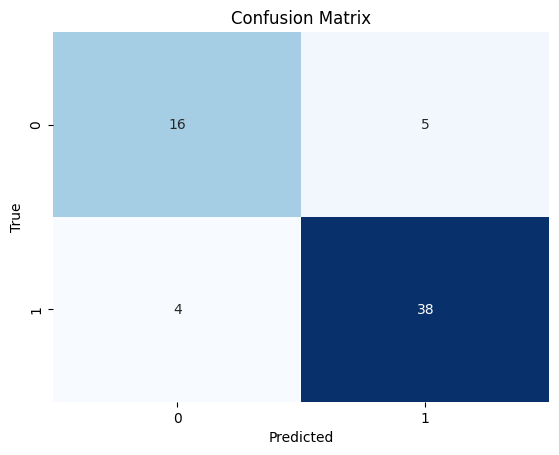

Confusion Matrix:
[[16  5]
 [ 4 38]]
0.8571428571428571 0.09523809523809523 0.8803088803088804
After fine tuning set
2/2 [==============================] - 1s 48ms/step


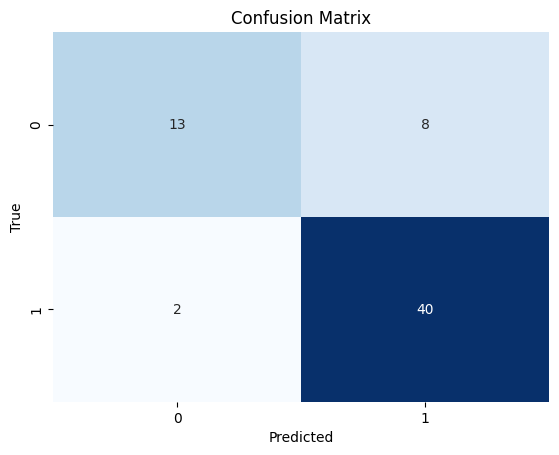

Confusion Matrix:
[[13  8]
 [ 2 40]]
0.8412698412698413 0.047619047619047616 0.8933839022334596
Before fine tuning set
1/1 [==============================] - 0s 26ms/step


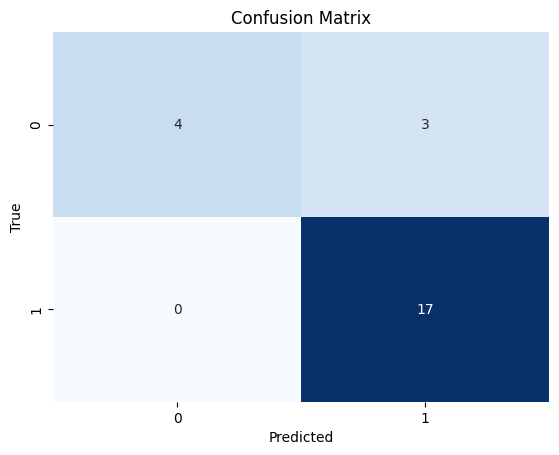

Confusion Matrix:
[[ 4  3]
 [ 0 17]]
0.875 0.0 0.9333333333333333
After fine tuning set
1/1 [==============================] - 0s 27ms/step


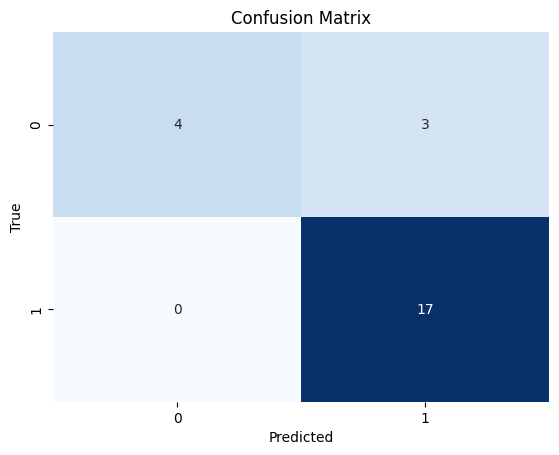

Confusion Matrix:
[[ 4  3]
 [ 0 17]]
0.875 0.0 0.9333333333333333


In [42]:
# vgg_model.show_confusion_matrix()
# vgg_model.show_confusion_matrix(test_data=(X_test_img_std, X_test_ftr_std, y_test))

# inception_model.show_confusion_matrix()
# inception_model.show_confusion_matrix(test_data=(X_test_img_std, X_test_ftr_std, y_test))

resnet_model.show_confusion_matrix(fancy=True)
resnet_model.show_confusion_matrix(fancy=True, test_data=(X_test_img_std, X_test_ftr_std, y_test))
# resnet_model_wosym.show_confusion_matrix()
# resnet_model_wosym.show_confusion_matrix(test_data=(X_test_img_std, X_test_ftr_std, y_test))

FN
Indices: [19 51]


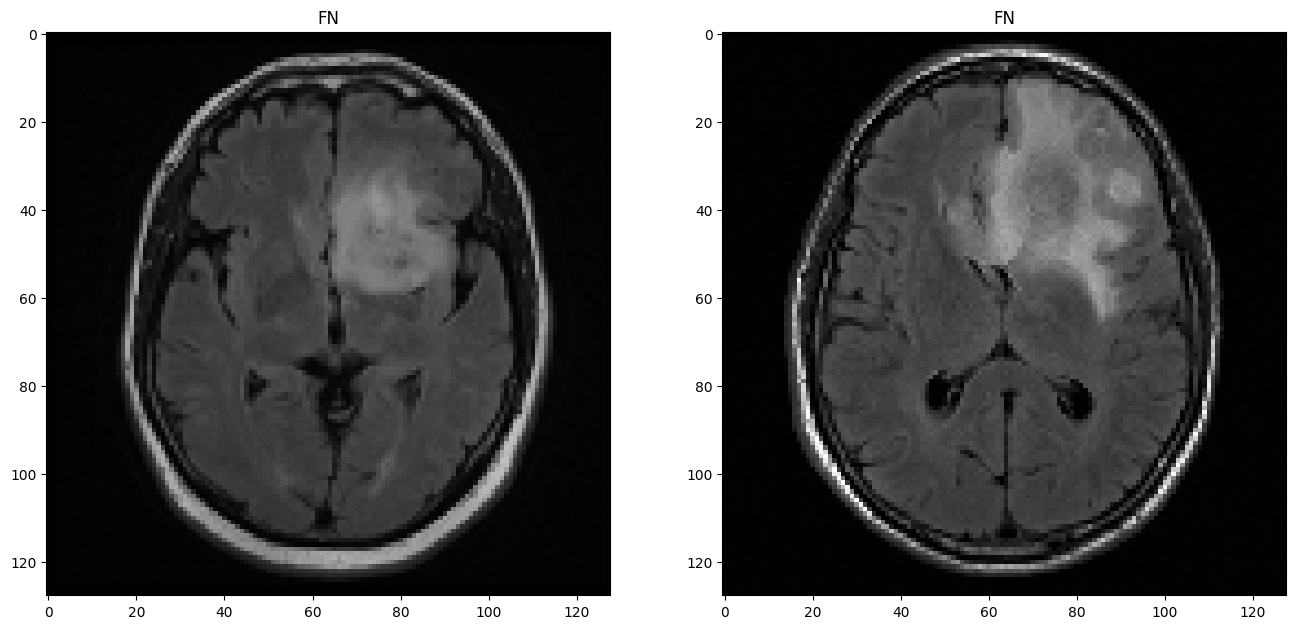

FP
Indices: [ 2  9 11 25 36 45 57 61]


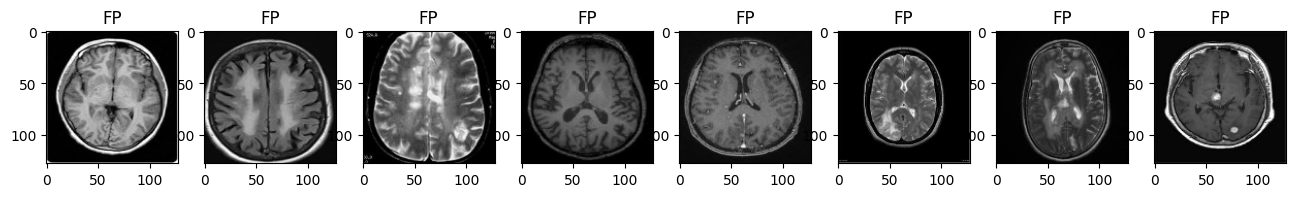

In [43]:
resnet_model.show_misclassified(X_val_img)